In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# Load the dataset
movie_df = pd.read_csv('/content/tmdb_5000_movies.csv')



In [4]:
# Fill missing overviews with an empty string
movie_df['overview'] = movie_df['overview'].fillna('')


In [5]:
# Weighted Average Calculation for IMDb Ratings
C = movie_df['vote_average'].mean()
m = movie_df['vote_count'].quantile(0.9)
q_movies = movie_df.copy().loc[movie_df['vote_count'] >= m]

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies = q_movies.sort_values('score', ascending=False)


In [6]:
# Display top 5 movies based on IMDb weighted rating
print("Top 5 Movies Based on IMDb Weighted Rating:")
print(q_movies[['title', 'vote_count', 'vote_average', 'score']].head(5))


Top 5 Movies Based on IMDb Weighted Rating:
                         title  vote_count  vote_average     score
1881  The Shawshank Redemption        8205           8.5  8.059258
662                 Fight Club        9413           8.3  7.939256
65             The Dark Knight       12002           8.2  7.920020
3232              Pulp Fiction        8428           8.3  7.904645
96                   Inception       13752           8.1  7.863239


In [7]:
# Content-based filtering using the 'overview' column
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_df['overview'])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)



In [8]:
# Create a mapping of movie titles to indices
indices = pd.Series(movie_df.index, index=movie_df['title']).drop_duplicates()



In [9]:
# Function to get recommendations based on cosine similarity
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    movie_similarity = [i[1] for i in sim_scores]

    return pd.DataFrame(zip(movie_df['title'].iloc[movie_indices], movie_similarity), columns=["title", "similarity"])



In [10]:
# Get content-based recommendations for 'The Godfather: Part II'
print("\nContent-Based Recommendations (Using Overview) for 'The Godfather: Part II':")
print(get_recommendations('The Godfather: Part II'))




Content-Based Recommendations (Using Overview) for 'The Godfather: Part II':
                      title  similarity
0             The Godfather    0.412329
1   The Godfather: Part III    0.259649
2  An American in Hollywood    0.121267
3       A Most Violent Year    0.111731
4                    Casino    0.110821


In [11]:
# Content-based filtering using additional features
# Leave only top 5 values for some features for simplification
features = ['keywords', 'genres', 'production_companies', 'production_countries']



In [12]:
# Remove spaces and convert features to lowercase
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ''

for feature in features:
    movie_df[feature] = movie_df[feature].apply(clean_data)



In [13]:
# Combine all selected features into a single string
def create_joined_features(x):
    return ' '.join([' '.join(x[f]) if isinstance(x[f], list) else str(x[f]) for f in features])

movie_df["join_features"] = movie_df.apply(create_joined_features, axis=1)



In [14]:
# Create count matrix and calculate cosine similarity based on combined features
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movie_df['join_features'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)



In [15]:
# Update indices for the new matrix
indices = pd.Series(movie_df.index, index=movie_df['title'])



In [16]:
# Get content-based recommendations using multiple features for 'The Godfather: Part II'
print("\nContent-Based Recommendations (Using Multiple Features) for 'The Godfather: Part II':")
print(get_recommendations('The Godfather: Part II', cosine_sim2))




Content-Based Recommendations (Using Multiple Features) for 'The Godfather: Part II':
                                     title  similarity
0                        Brooklyn's Finest    0.936145
1                          Southland Tales    0.930859
2                               15 Minutes    0.930598
3  Things to Do in Denver When You're Dead    0.929414
4                      The Devil's Rejects    0.926893


In [17]:
# Get content-based recommendations using multiple features for 'The Avengers'
print("\nContent-Based Recommendations (Using Multiple Features) for 'The Avengers':")
print(get_recommendations('The Avengers', cosine_sim2))



Content-Based Recommendations (Using Multiple Features) for 'The Avengers':
                                 title  similarity
0                              Ant-Man    0.970594
1  Captain America: The Winter Soldier    0.968913
2              Avengers: Age of Ultron    0.962965
3                           Iron Man 2    0.960213
4   Captain America: The First Avenger    0.959199


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity


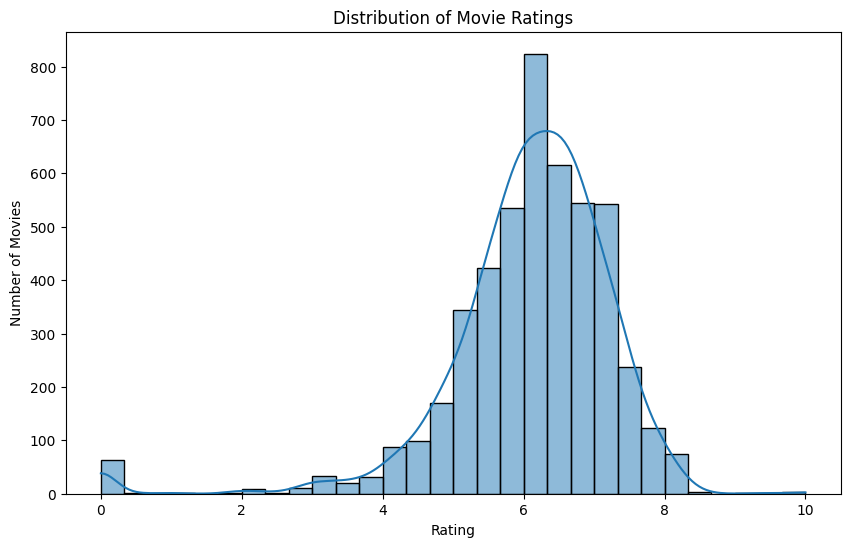

In [19]:
# Plot distribution of movie ratings
plt.figure(figsize=(10, 6))
sns.histplot(movie_df['vote_average'], bins=30, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.show()


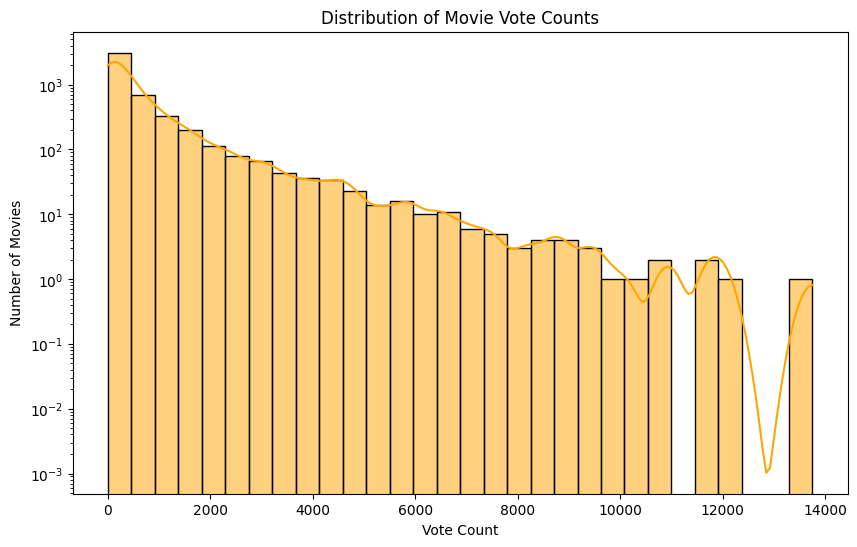

In [20]:
# Plot distribution of movie vote counts
plt.figure(figsize=(10, 6))
sns.histplot(movie_df['vote_count'], bins=30, kde=True, color='orange')
plt.title('Distribution of Movie Vote Counts')
plt.xlabel('Vote Count')
plt.ylabel('Number of Movies')
plt.yscale('log')  # Log scale to handle skewness
plt.show()


<ipython-input-21-2be46e0ef203>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score', y='title', data=top_10_movies, palette='viridis')


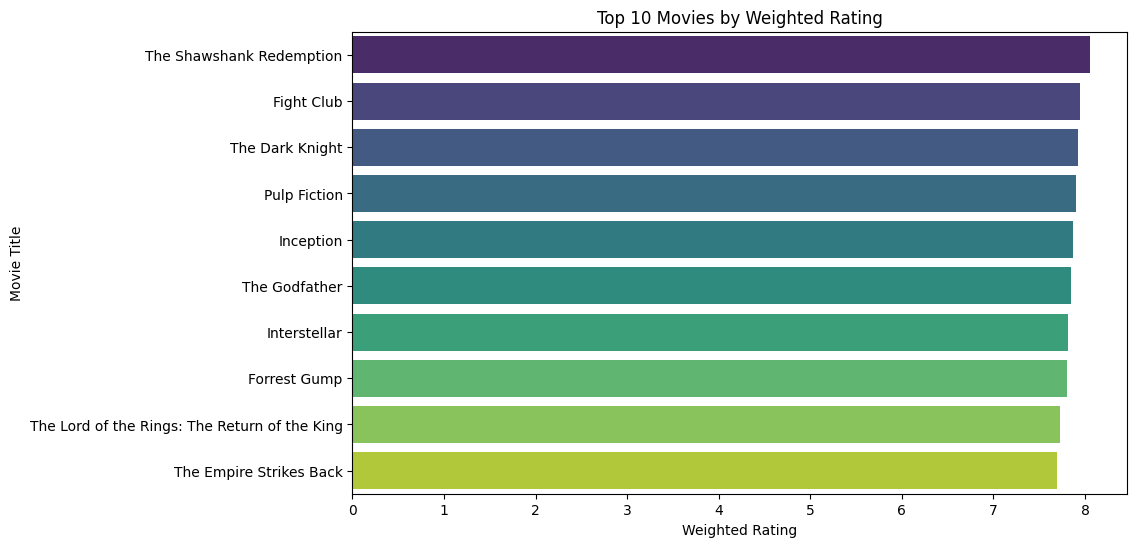

In [21]:
# Calculate IMDb weighted rating
C = movie_df['vote_average'].mean()
m = movie_df['vote_count'].quantile(0.9)
q_movies = movie_df.copy().loc[movie_df['vote_count'] >= m]

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
top_10_movies = q_movies.sort_values('score', ascending=False).head(10)

# Plot top 10 movies by weighted rating
plt.figure(figsize=(10, 6))
sns.barplot(x='score', y='title', data=top_10_movies, palette='viridis')
plt.title('Top 10 Movies by Weighted Rating')
plt.xlabel('Weighted Rating')
plt.ylabel('Movie Title')
plt.show()


<ipython-input-22-4d71b14eb493>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=genre_count_df.sort_values('count', ascending=False), palette='coolwarm')


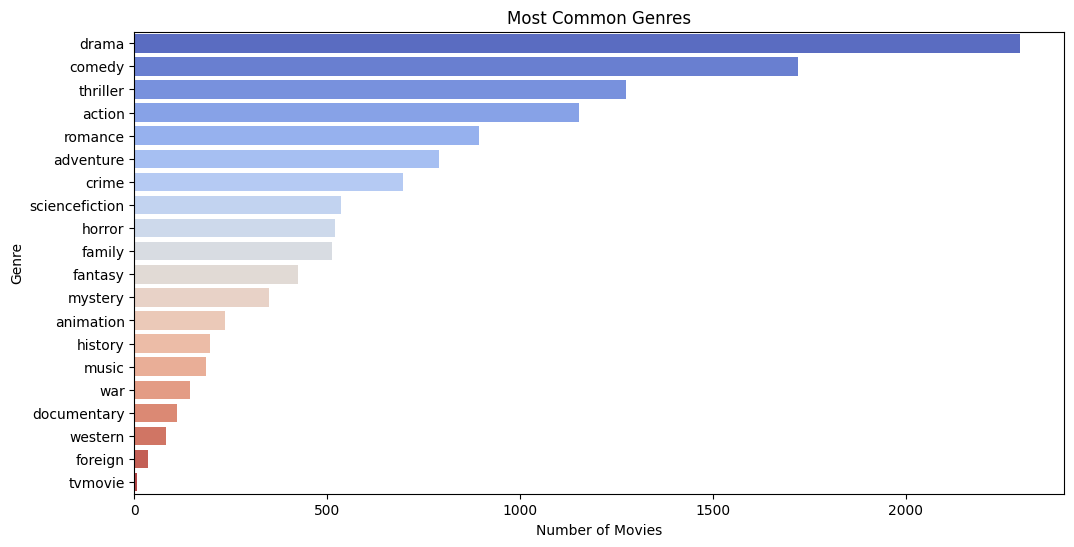

In [22]:
from collections import Counter

# Assuming 'genres' column contains lists of genres
# Preprocess genres column
movie_df['genres'] = movie_df['genres'].fillna('[]').apply(eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Count the frequency of each genre
genre_count = Counter([genre for sublist in movie_df['genres'] for genre in sublist])
genre_count_df = pd.DataFrame.from_dict(genre_count, orient='index').reset_index()
genre_count_df.columns = ['genre', 'count']

# Plot genre popularity
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='genre', data=genre_count_df.sort_values('count', ascending=False), palette='coolwarm')
plt.title('Most Common Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()


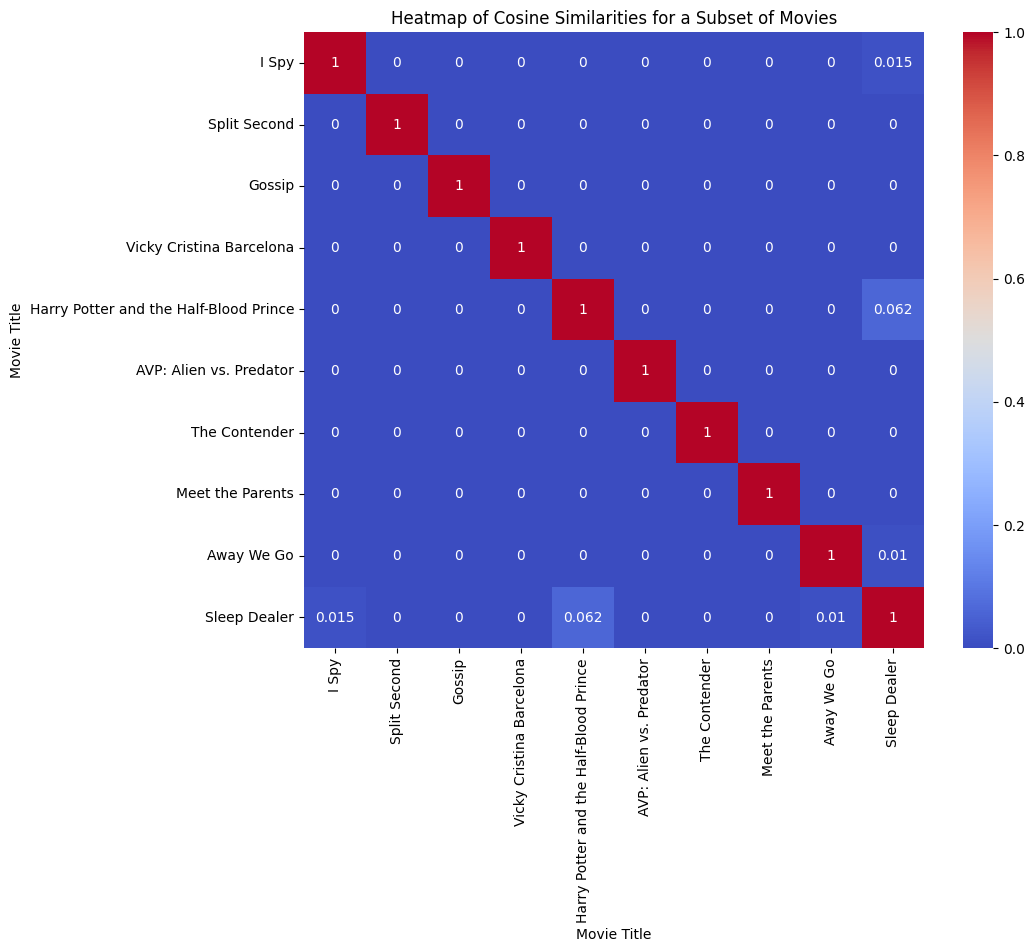

In [23]:
# Use a small subset for visualization
subset_movies = movie_df['title'].sample(10, random_state=42)
subset_indices = [indices[title] for title in subset_movies]

# Calculate similarity scores
cosine_sim_subset = cosine_sim[subset_indices][:, subset_indices]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_subset, xticklabels=subset_movies, yticklabels=subset_movies, annot=True, cmap='coolwarm')
plt.title('Heatmap of Cosine Similarities for a Subset of Movies')
plt.xlabel('Movie Title')
plt.ylabel('Movie Title')
plt.show()
